In [39]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from matplotlib import pyplot as plt

# Load data

In [2]:
def loadData(path, filter_numeric=True):
    df = pd.read_csv(path,keep_default_na=False)
    df = df.drop(columns=['Id'])
    if filter_numeric:
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        df = df[numeric_columns]

    return df

df = loadData("train.csv")
X = df.drop(columns=['SalePrice'])
Y = df[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train),len(X_test))

1168 292


In [3]:
# Standardize data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
scaler_X.fit(X_train)
scaler_Y.fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_Y.transform(y_train)
y_test_scaled = scaler_Y.transform(y_test)


# Search parameters

In [37]:
# Grid serach params
def param_search(model, params, X, y, verbose=1, K=5):
    grid_search = GridSearchCV(
        model, params, cv=K, scoring='neg_mean_squared_error', refit=True, return_train_score=True, verbose=verbose)
    grid_search.fit(X, y)
    return grid_search


def table_results(res):
    print(f"Best parameters: {res.best_params_}")
    res = res.cv_results_
    df = pd.DataFrame(res['params'])
    df['RMSE normalized'] = res['mean_test_score']
    return df.to_string(index=False)


def evaluate_model(model):
    y_pred = model.predict(X_test_scaled).reshape(-1, 1)
    normed = root_mean_squared_error(y_test_scaled, y_pred)
    print(
        f"RMSE of normalized predictions: {normed:.3f}")

    y_pred = scaler_Y.inverse_transform(y_pred)
    unnormed = root_mean_squared_error(y_test, y_pred)
    print(
        f"RMSE of unnormalized predictions: {unnormed:.2f}")
    return normed, unnormed

In [24]:
# model 1
model = Ridge()
parameters = {'alpha': np.logspace(-5, 1, 10), 'fit_intercept': [False, True]}
res = param_search(model, parameters, X_train_scaled, y_train_scaled, K=3)
print(table_results(res))
evaluate_model(res.best_estimator_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'alpha': 10.0, 'fit_intercept': False}
    alpha  fit_intercept  RMSE normalized
 0.000010          False        -0.249391
 0.000010           True        -0.249413
 0.000046          False        -0.249391
 0.000046           True        -0.249413
 0.000215          False        -0.249390
 0.000215           True        -0.249413
 0.001000          False        -0.249390
 0.001000           True        -0.249413
 0.004642          False        -0.249390
 0.004642           True        -0.249412
 0.021544          False        -0.249387
 0.021544           True        -0.249410
 0.100000          False        -0.249375
 0.100000           True        -0.249397
 0.464159          False        -0.249317
 0.464159           True        -0.249340
 2.154435          False        -0.249056
 2.154435           True        -0.249078
10.000000          False        -0.247948
10.000000           True        -0.247970


In [15]:
# Model 2
model = GradientBoostingRegressor()
parameters ={
   'n_estimators': [25, 50, 100],
   'learning_rate': [0.001, 0.01, 0.1],
   'max_depth': [3, 5, 9],
   'subsample':[0.8, 0.9, 1.0],
}
res = param_search(model, parameters, X_train_scaled,y_train_scaled.squeeze(), K=3)
print(table_results(res))
evaluate_model(res.best_estimator_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
 learning_rate  max_depth  n_estimators  subsample  RMSE normalized
         0.001          3            25        0.8        -0.968408
         0.001          3            25        0.9        -0.968670
         0.001          3            25        1.0        -0.968513
         0.001          3            50        0.8        -0.937278
         0.001          3            50        0.9        -0.936589
         0.001          3            50        1.0        -0.936828
         0.001          3           100        0.8        -0.876920
         0.001          3           100        0.9        -0.876815
         0.001          3           100        1.0        -0.878100
         0.001          5            25        0.8        -0.963734
         0.001          5            25        0.9        -0.963111
         0.001          5  

In [16]:
# Model 3
model = MLPRegressor()
parameters ={
    "hidden_layer_sizes": [
        (32),
        (32,32),
        (32,32,32),
        (128),
        (128,128),
        (512),
        (512,512)
    ],
    "learning_rate_init":[
        0.001, 0.01,0.1
    ]
}
res = param_search(model, parameters, X_train_scaled,y_train_scaled.squeeze(), K=3)
print(table_results(res))
evaluate_model(res.best_estimator_)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


/home/matty/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matty/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matty/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matty/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matty/.local/lib/python3.11/site-packages/skle

Best parameters: {'hidden_layer_sizes': (512, 512), 'learning_rate_init': 0.001}
hidden_layer_sizes  learning_rate_init  RMSE normalized
                32               0.001        -0.245793
                32               0.010        -0.322436
                32               0.100        -0.339203
          (32, 32)               0.001        -0.272423
          (32, 32)               0.010        -0.270304
          (32, 32)               0.100        -0.333158
      (32, 32, 32)               0.001        -0.289484
      (32, 32, 32)               0.010        -0.257499
      (32, 32, 32)               0.100        -0.795019
               128               0.001        -0.283202
               128               0.010        -0.287071
               128               0.100        -0.325101
        (128, 128)               0.001        -0.294699
        (128, 128)               0.010        -0.270799
        (128, 128)               0.100        -0.419741
               512     

# Training size experiment

In [40]:
model1 = Ridge(**{'alpha': 10.0, 'fit_intercept': False})
model2 = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0})
model3 = MLPRegressor(**{'hidden_layer_sizes': (512, 512), 'learning_rate_init': 0.001})
models = {model1:'ridge', model2:'gradientboosting', model3:'mlp'}

Ridge(alpha=10.0, fit_intercept=False)
RMSE of normalized predictions: 0.782
RMSE of unnormalized predictions: 60370.76
RMSE of normalized predictions: 0.527
RMSE of unnormalized predictions: 40689.35
RMSE of normalized predictions: 0.467
RMSE of unnormalized predictions: 36099.21
RMSE of normalized predictions: 0.461
RMSE of unnormalized predictions: 35583.62
RMSE of normalized predictions: 0.512
RMSE of unnormalized predictions: 39519.07
RMSE of normalized predictions: 0.483
RMSE of unnormalized predictions: 37332.86
GradientBoostingRegressor()
RMSE of normalized predictions: 0.987
RMSE of unnormalized predictions: 76230.48
RMSE of normalized predictions: 0.675
RMSE of unnormalized predictions: 52100.08
RMSE of normalized predictions: 0.513
RMSE of unnormalized predictions: 39625.07
RMSE of normalized predictions: 0.381
RMSE of unnormalized predictions: 29401.40
RMSE of normalized predictions: 0.374
RMSE of unnormalized predictions: 28864.81
RMSE of normalized predictions: 0.378
RMSE

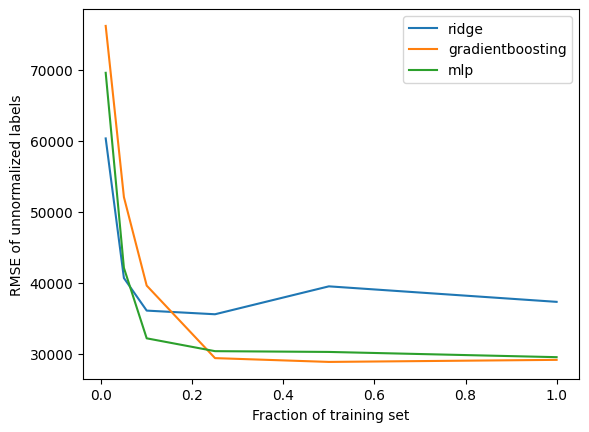

In [44]:
pcts = [0.01, 0.05, 0.10, 0.25, 0.50, 1.00]


for model in models:
    print(model)
    losses = []
    for pct in pcts:
        m2 = clone(model)
        idx = int(len(X_train_scaled) * pct)
        xt = X_train_scaled[:idx]
        yt = y_train_scaled[:idx].squeeze()
        m2.fit(xt, yt)
        normed,unnormed = evaluate_model(m2)
        losses.append(unnormed)
    plt.plot(pcts,losses, label=models[model])

plt.xlabel("Fraction of training set")
plt.ylabel("RMSE of unnormalized labels")

plt.legend()
plt.show()
        